In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2102128, 828)
(2102128, 8)
validation
(318280, 828)
(318280, 8)
test
(190288, 828)
(190288, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/211 [..............................] - ETA: 4:18 - loss: 2.2704 - STD: 0.0768 - MAE: 0.2194

  5/211 [..............................] - ETA: 3s - loss: 2.1179 - STD: 0.0518 - MAE: 0.2170  

  9/211 [>.............................] - ETA: 3s - loss: 2.1013 - STD: 0.0504 - MAE: 0.2166

 13/211 [>.............................] - ETA: 3s - loss: 2.0879 - STD: 0.0458 - MAE: 0.2166

 16/211 [=>............................] - ETA: 3s - loss: 2.0814 - STD: 0.0436 - MAE: 0.2166

 20/211 [=>............................] - ETA: 2s - loss: 2.0766 - STD: 0.0413 - MAE: 0.2167

 24/211 [==>...........................] - ETA: 2s - loss: 2.0716 - STD: 0.0392 - MAE: 0.2167

 28/211 [==>...........................] - ETA: 2s - loss: 2.0664 - STD: 0.0384 - MAE: 0.2166

 32/211 [===>..........................] - ETA: 2s - loss: 2.0606 - STD: 0.0380 - MAE: 0.2164

 36/211 [====>.........................] - ETA: 2s - loss: 2.0531 - STD: 0.0382 - MAE: 0.2162

 40/211 [====>.........................] - ETA: 2s - loss: 2.0433 - STD: 0.0388 - MAE: 0.2158

 44/211 [=====>........................] - ETA: 2s - loss: 2.0318 - STD: 0.0405 - MAE: 0.2153

 48/211 [=====>........................] - ETA: 2s - loss: 2.0195 - STD: 0.0428 - MAE: 0.2147

 52/211 [======>.......................] - ETA: 2s - loss: 2.0065 - STD: 0.0452 - MAE: 0.2141

 56/211 [======>.......................] - ETA: 2s - loss: 1.9927 - STD: 0.0474 - MAE: 0.2134

 60/211 [=======>......................] - ETA: 2s - loss: 1.9778 - STD: 0.0496 - MAE: 0.2127

 64/211 [========>.....................] - ETA: 2s - loss: 1.9627 - STD: 0.0518 - MAE: 0.2120

 68/211 [========>.....................] - ETA: 2s - loss: 1.9472 - STD: 0.0539 - MAE: 0.2113

 72/211 [=========>....................] - ETA: 2s - loss: 1.9306 - STD: 0.0562 - MAE: 0.2104

 76/211 [=========>....................] - ETA: 2s - loss: 1.9137 - STD: 0.0586 - MAE: 0.2095

 80/211 [==========>...................] - ETA: 2s - loss: 1.8973 - STD: 0.0613 - MAE: 0.2085

 84/211 [==========>...................] - ETA: 1s - loss: 1.8817 - STD: 0.0642 - MAE: 0.2074

 88/211 [===========>..................] - ETA: 1s - loss: 1.8664 - STD: 0.0669 - MAE: 0.2064

 92/211 [============>.................] - ETA: 1s - loss: 1.8518 - STD: 0.0695 - MAE: 0.2054

 96/211 [============>.................] - ETA: 1s - loss: 1.8378 - STD: 0.0719 - MAE: 0.2045

 99/211 [=============>................] - ETA: 2s - loss: 1.8301 - STD: 0.0737 - MAE: 0.2038

103/211 [=============>................] - ETA: 2s - loss: 1.8168 - STD: 0.0759 - MAE: 0.2029

107/211 [==============>...............] - ETA: 2s - loss: 1.8041 - STD: 0.0781 - MAE: 0.2021

111/211 [==============>...............] - ETA: 2s - loss: 1.7921 - STD: 0.0802 - MAE: 0.2012

115/211 [===============>..............] - ETA: 1s - loss: 1.7803 - STD: 0.0822 - MAE: 0.2004

119/211 [===============>..............] - ETA: 1s - loss: 1.7690 - STD: 0.0842 - MAE: 0.1996

123/211 [================>.............] - ETA: 1s - loss: 1.7579 - STD: 0.0861 - MAE: 0.1988

127/211 [=================>............] - ETA: 1s - loss: 1.7473 - STD: 0.0879 - MAE: 0.1981

131/211 [=================>............] - ETA: 1s - loss: 1.7373 - STD: 0.0897 - MAE: 0.1973

135/211 [==================>...........] - ETA: 1s - loss: 1.7277 - STD: 0.0914 - MAE: 0.1966

139/211 [==================>...........] - ETA: 1s - loss: 1.7185 - STD: 0.0930 - MAE: 0.1959

143/211 [===================>..........] - ETA: 1s - loss: 1.7095 - STD: 0.0946 - MAE: 0.1953

147/211 [===================>..........] - ETA: 1s - loss: 1.7014 - STD: 0.0961 - MAE: 0.1946

151/211 [====================>.........] - ETA: 1s - loss: 1.6931 - STD: 0.0976 - MAE: 0.1940

155/211 [=====================>........] - ETA: 1s - loss: 1.6853 - STD: 0.0990 - MAE: 0.1934

159/211 [=====================>........] - ETA: 0s - loss: 1.6778 - STD: 0.1003 - MAE: 0.1929

163/211 [======================>.......] - ETA: 0s - loss: 1.6702 - STD: 0.1016 - MAE: 0.1923

167/211 [======================>.......] - ETA: 0s - loss: 1.6631 - STD: 0.1029 - MAE: 0.1917

171/211 [=======================>......] - ETA: 0s - loss: 1.6562 - STD: 0.1041 - MAE: 0.1912

175/211 [=======================>......] - ETA: 0s - loss: 1.6498 - STD: 0.1052 - MAE: 0.1907

179/211 [========================>.....] - ETA: 0s - loss: 1.6434 - STD: 0.1063 - MAE: 0.1902

183/211 [=========================>....] - ETA: 0s - loss: 1.6373 - STD: 0.1074 - MAE: 0.1897

187/211 [=========================>....] - ETA: 0s - loss: 1.6313 - STD: 0.1085 - MAE: 0.1893

191/211 [==========================>...] - ETA: 0s - loss: 1.6256 - STD: 0.1095 - MAE: 0.1888

195/211 [==========================>...] - ETA: 0s - loss: 1.6200 - STD: 0.1105 - MAE: 0.1884

199/211 [===========================>..] - ETA: 0s - loss: 1.6145 - STD: 0.1115 - MAE: 0.1879

203/211 [===========================>..] - ETA: 0s - loss: 1.6091 - STD: 0.1124 - MAE: 0.1875

207/211 [============================>.] - ETA: 0s - loss: 1.6041 - STD: 0.1133 - MAE: 0.1871

211/211 [==============================] - ETA: 0s - loss: 1.5992 - STD: 0.1142 - MAE: 0.1867

211/211 [==============================] - 6s 23ms/step - loss: 1.5992 - STD: 0.1142 - MAE: 0.1867 - val_loss: 1.6154 - val_STD: 0.1625 - val_MAE: 0.1778


Epoch 2/10000


  1/211 [..............................] - ETA: 8s - loss: 1.3485 - STD: 0.1586 - MAE: 0.1666

  5/211 [..............................] - ETA: 3s - loss: 1.3407 - STD: 0.1600 - MAE: 0.1660

  9/211 [>.............................] - ETA: 3s - loss: 1.3372 - STD: 0.1599 - MAE: 0.1658

 13/211 [>.............................] - ETA: 3s - loss: 1.3376 - STD: 0.1600 - MAE: 0.1659

 17/211 [=>............................] - ETA: 2s - loss: 1.3383 - STD: 0.1604 - MAE: 0.1658

 21/211 [=>............................] - ETA: 2s - loss: 1.3385 - STD: 0.1605 - MAE: 0.1658

 25/211 [==>...........................] - ETA: 2s - loss: 1.3359 - STD: 0.1607 - MAE: 0.1656

 29/211 [===>..........................] - ETA: 2s - loss: 1.3338 - STD: 0.1608 - MAE: 0.1655

 33/211 [===>..........................] - ETA: 2s - loss: 1.3308 - STD: 0.1612 - MAE: 0.1652

 37/211 [====>.........................] - ETA: 2s - loss: 1.3292 - STD: 0.1614 - MAE: 0.1651

 41/211 [====>.........................] - ETA: 2s - loss: 1.3272 - STD: 0.1616 - MAE: 0.1649

 45/211 [=====>........................] - ETA: 2s - loss: 1.3252 - STD: 0.1618 - MAE: 0.1648

 49/211 [=====>........................] - ETA: 2s - loss: 1.3243 - STD: 0.1620 - MAE: 0.1647

 53/211 [======>.......................] - ETA: 2s - loss: 1.3221 - STD: 0.1622 - MAE: 0.1645

 56/211 [======>.......................] - ETA: 2s - loss: 1.3210 - STD: 0.1624 - MAE: 0.1644

 60/211 [=======>......................] - ETA: 2s - loss: 1.3197 - STD: 0.1626 - MAE: 0.1643

 64/211 [========>.....................] - ETA: 2s - loss: 1.3177 - STD: 0.1628 - MAE: 0.1641

 68/211 [========>.....................] - ETA: 2s - loss: 1.3162 - STD: 0.1631 - MAE: 0.1639

 72/211 [=========>....................] - ETA: 2s - loss: 1.3144 - STD: 0.1633 - MAE: 0.1638

 76/211 [=========>....................] - ETA: 2s - loss: 1.3132 - STD: 0.1635 - MAE: 0.1637

 80/211 [==========>...................] - ETA: 2s - loss: 1.3117 - STD: 0.1637 - MAE: 0.1635

 84/211 [==========>...................] - ETA: 2s - loss: 1.3102 - STD: 0.1639 - MAE: 0.1634

 88/211 [===========>..................] - ETA: 1s - loss: 1.3091 - STD: 0.1640 - MAE: 0.1633

 92/211 [============>.................] - ETA: 1s - loss: 1.3072 - STD: 0.1642 - MAE: 0.1632

 96/211 [============>.................] - ETA: 1s - loss: 1.3060 - STD: 0.1644 - MAE: 0.1630

100/211 [=============>................] - ETA: 1s - loss: 1.3047 - STD: 0.1646 - MAE: 0.1629

104/211 [=============>................] - ETA: 1s - loss: 1.3037 - STD: 0.1647 - MAE: 0.1628

108/211 [==============>...............] - ETA: 1s - loss: 1.3021 - STD: 0.1649 - MAE: 0.1627

112/211 [==============>...............] - ETA: 1s - loss: 1.3004 - STD: 0.1651 - MAE: 0.1626

116/211 [===============>..............] - ETA: 1s - loss: 1.2992 - STD: 0.1653 - MAE: 0.1624

120/211 [================>.............] - ETA: 1s - loss: 1.2977 - STD: 0.1654 - MAE: 0.1623

124/211 [================>.............] - ETA: 1s - loss: 1.2965 - STD: 0.1656 - MAE: 0.1622

128/211 [=================>............] - ETA: 1s - loss: 1.2948 - STD: 0.1658 - MAE: 0.1621

131/211 [=================>............] - ETA: 1s - loss: 1.2937 - STD: 0.1660 - MAE: 0.1620

135/211 [==================>...........] - ETA: 1s - loss: 1.2923 - STD: 0.1662 - MAE: 0.1618

139/211 [==================>...........] - ETA: 1s - loss: 1.2907 - STD: 0.1664 - MAE: 0.1617

143/211 [===================>..........] - ETA: 1s - loss: 1.2893 - STD: 0.1665 - MAE: 0.1616

147/211 [===================>..........] - ETA: 1s - loss: 1.2877 - STD: 0.1667 - MAE: 0.1614

151/211 [====================>.........] - ETA: 0s - loss: 1.2864 - STD: 0.1669 - MAE: 0.1613

155/211 [=====================>........] - ETA: 0s - loss: 1.2846 - STD: 0.1671 - MAE: 0.1612

159/211 [=====================>........] - ETA: 0s - loss: 1.2830 - STD: 0.1673 - MAE: 0.1610

163/211 [======================>.......] - ETA: 0s - loss: 1.2818 - STD: 0.1674 - MAE: 0.1609

167/211 [======================>.......] - ETA: 0s - loss: 1.2804 - STD: 0.1676 - MAE: 0.1608

170/211 [=======================>......] - ETA: 0s - loss: 1.2796 - STD: 0.1678 - MAE: 0.1607

174/211 [=======================>......] - ETA: 0s - loss: 1.2784 - STD: 0.1680 - MAE: 0.1605

178/211 [========================>.....] - ETA: 0s - loss: 1.2772 - STD: 0.1681 - MAE: 0.1604

182/211 [========================>.....] - ETA: 0s - loss: 1.2759 - STD: 0.1683 - MAE: 0.1603

186/211 [=========================>....] - ETA: 0s - loss: 1.2748 - STD: 0.1685 - MAE: 0.1602

190/211 [==========================>...] - ETA: 0s - loss: 1.2737 - STD: 0.1686 - MAE: 0.1601

194/211 [==========================>...] - ETA: 0s - loss: 1.2724 - STD: 0.1688 - MAE: 0.1600

198/211 [===========================>..] - ETA: 0s - loss: 1.2714 - STD: 0.1690 - MAE: 0.1599

202/211 [===========================>..] - ETA: 0s - loss: 1.2706 - STD: 0.1691 - MAE: 0.1598

206/211 [============================>.] - ETA: 0s - loss: 1.2693 - STD: 0.1693 - MAE: 0.1597

210/211 [============================>.] - ETA: 0s - loss: 1.2682 - STD: 0.1694 - MAE: 0.1596

211/211 [==============================] - 4s 18ms/step - loss: 1.2680 - STD: 0.1695 - MAE: 0.1595 - val_loss: 1.5089 - val_STD: 0.1766 - val_MAE: 0.1676


Epoch 3/10000


  1/211 [..............................] - ETA: 9s - loss: 1.2118 - STD: 0.1773 - MAE: 0.1541

  5/211 [..............................] - ETA: 3s - loss: 1.1979 - STD: 0.1772 - MAE: 0.1534

  9/211 [>.............................] - ETA: 3s - loss: 1.1988 - STD: 0.1775 - MAE: 0.1535

 13/211 [>.............................] - ETA: 3s - loss: 1.1986 - STD: 0.1775 - MAE: 0.1535

 17/211 [=>............................] - ETA: 3s - loss: 1.1955 - STD: 0.1778 - MAE: 0.1532

 21/211 [=>............................] - ETA: 2s - loss: 1.1939 - STD: 0.1782 - MAE: 0.1530

 25/211 [==>...........................] - ETA: 2s - loss: 1.1918 - STD: 0.1785 - MAE: 0.1528

 29/211 [===>..........................] - ETA: 2s - loss: 1.1905 - STD: 0.1787 - MAE: 0.1527

 33/211 [===>..........................] - ETA: 2s - loss: 1.1886 - STD: 0.1789 - MAE: 0.1525

 37/211 [====>.........................] - ETA: 2s - loss: 1.1876 - STD: 0.1791 - MAE: 0.1524

 41/211 [====>.........................] - ETA: 2s - loss: 1.1929 - STD: 0.1793 - MAE: 0.1525

 45/211 [=====>........................] - ETA: 2s - loss: 1.1935 - STD: 0.1794 - MAE: 0.1525

 49/211 [=====>........................] - ETA: 2s - loss: 1.1930 - STD: 0.1794 - MAE: 0.1525

 53/211 [======>.......................] - ETA: 2s - loss: 1.1918 - STD: 0.1796 - MAE: 0.1523

 57/211 [=======>......................] - ETA: 2s - loss: 1.1901 - STD: 0.1797 - MAE: 0.1522

 61/211 [=======>......................] - ETA: 2s - loss: 1.1888 - STD: 0.1797 - MAE: 0.1522

 65/211 [========>.....................] - ETA: 2s - loss: 1.1878 - STD: 0.1798 - MAE: 0.1521

 69/211 [========>.....................] - ETA: 2s - loss: 1.1865 - STD: 0.1800 - MAE: 0.1520

 73/211 [=========>....................] - ETA: 2s - loss: 1.1854 - STD: 0.1801 - MAE: 0.1519

 77/211 [=========>....................] - ETA: 2s - loss: 1.1852 - STD: 0.1802 - MAE: 0.1518

 81/211 [==========>...................] - ETA: 1s - loss: 1.1845 - STD: 0.1804 - MAE: 0.1517

 85/211 [===========>..................] - ETA: 1s - loss: 1.1832 - STD: 0.1806 - MAE: 0.1516

 89/211 [===========>..................] - ETA: 1s - loss: 1.1824 - STD: 0.1807 - MAE: 0.1515

 93/211 [============>.................] - ETA: 1s - loss: 1.1811 - STD: 0.1808 - MAE: 0.1514

 97/211 [============>.................] - ETA: 1s - loss: 1.1803 - STD: 0.1810 - MAE: 0.1513

101/211 [=============>................] - ETA: 1s - loss: 1.1791 - STD: 0.1811 - MAE: 0.1512

105/211 [=============>................] - ETA: 1s - loss: 1.1784 - STD: 0.1812 - MAE: 0.1511

109/211 [==============>...............] - ETA: 1s - loss: 1.1772 - STD: 0.1813 - MAE: 0.1510

113/211 [===============>..............] - ETA: 1s - loss: 1.1767 - STD: 0.1815 - MAE: 0.1509

117/211 [===============>..............] - ETA: 1s - loss: 1.1758 - STD: 0.1816 - MAE: 0.1509

121/211 [================>.............] - ETA: 1s - loss: 1.1744 - STD: 0.1817 - MAE: 0.1507

125/211 [================>.............] - ETA: 1s - loss: 1.1733 - STD: 0.1818 - MAE: 0.1506

129/211 [=================>............] - ETA: 1s - loss: 1.1721 - STD: 0.1820 - MAE: 0.1505

133/211 [=================>............] - ETA: 1s - loss: 1.1712 - STD: 0.1821 - MAE: 0.1504

137/211 [==================>...........] - ETA: 1s - loss: 1.1707 - STD: 0.1822 - MAE: 0.1504

141/211 [===================>..........] - ETA: 1s - loss: 1.1713 - STD: 0.1824 - MAE: 0.1504

145/211 [===================>..........] - ETA: 1s - loss: 1.1710 - STD: 0.1824 - MAE: 0.1503

149/211 [====================>.........] - ETA: 0s - loss: 1.1704 - STD: 0.1825 - MAE: 0.1503

153/211 [====================>.........] - ETA: 0s - loss: 1.1697 - STD: 0.1826 - MAE: 0.1502

157/211 [=====================>........] - ETA: 0s - loss: 1.1693 - STD: 0.1827 - MAE: 0.1501

161/211 [=====================>........] - ETA: 0s - loss: 1.1687 - STD: 0.1828 - MAE: 0.1501

165/211 [======================>.......] - ETA: 0s - loss: 1.1681 - STD: 0.1829 - MAE: 0.1500

170/211 [=======================>......] - ETA: 0s - loss: 1.1674 - STD: 0.1830 - MAE: 0.1499

174/211 [=======================>......] - ETA: 0s - loss: 1.1665 - STD: 0.1831 - MAE: 0.1498

178/211 [========================>.....] - ETA: 0s - loss: 1.1657 - STD: 0.1832 - MAE: 0.1498

182/211 [========================>.....] - ETA: 0s - loss: 1.1646 - STD: 0.1833 - MAE: 0.1497

186/211 [=========================>....] - ETA: 0s - loss: 1.1639 - STD: 0.1834 - MAE: 0.1496

190/211 [==========================>...] - ETA: 0s - loss: 1.1634 - STD: 0.1835 - MAE: 0.1495

194/211 [==========================>...] - ETA: 0s - loss: 1.1626 - STD: 0.1836 - MAE: 0.1495

198/211 [===========================>..] - ETA: 0s - loss: 1.1619 - STD: 0.1837 - MAE: 0.1494

202/211 [===========================>..] - ETA: 0s - loss: 1.1611 - STD: 0.1838 - MAE: 0.1493

206/211 [============================>.] - ETA: 0s - loss: 1.1602 - STD: 0.1839 - MAE: 0.1492

210/211 [============================>.] - ETA: 0s - loss: 1.1590 - STD: 0.1840 - MAE: 0.1491

211/211 [==============================] - 4s 17ms/step - loss: 1.1588 - STD: 0.1841 - MAE: 0.1491 - val_loss: 1.4223 - val_STD: 0.1867 - val_MAE: 0.1600


Epoch 4/10000


  1/211 [..............................] - ETA: 10s - loss: 1.1027 - STD: 0.1901 - MAE: 0.1438

  5/211 [..............................] - ETA: 3s - loss: 1.1061 - STD: 0.1900 - MAE: 0.1441 

  9/211 [>.............................] - ETA: 3s - loss: 1.1048 - STD: 0.1900 - MAE: 0.1441

 13/211 [>.............................] - ETA: 3s - loss: 1.1049 - STD: 0.1899 - MAE: 0.1441

 17/211 [=>............................] - ETA: 3s - loss: 1.1085 - STD: 0.1902 - MAE: 0.1442

 21/211 [=>............................] - ETA: 2s - loss: 1.1087 - STD: 0.1903 - MAE: 0.1442

 25/211 [==>...........................] - ETA: 2s - loss: 1.1076 - STD: 0.1903 - MAE: 0.1442

 29/211 [===>..........................] - ETA: 2s - loss: 1.1060 - STD: 0.1904 - MAE: 0.1440

 33/211 [===>..........................] - ETA: 2s - loss: 1.1098 - STD: 0.1905 - MAE: 0.1442

 37/211 [====>.........................] - ETA: 2s - loss: 1.1125 - STD: 0.1908 - MAE: 0.1442

 41/211 [====>.........................] - ETA: 2s - loss: 1.1167 - STD: 0.1908 - MAE: 0.1444

 45/211 [=====>........................] - ETA: 2s - loss: 1.1171 - STD: 0.1909 - MAE: 0.1444

 49/211 [=====>........................] - ETA: 2s - loss: 1.1164 - STD: 0.1909 - MAE: 0.1444

 53/211 [======>.......................] - ETA: 2s - loss: 1.1163 - STD: 0.1908 - MAE: 0.1444

 57/211 [=======>......................] - ETA: 2s - loss: 1.1152 - STD: 0.1909 - MAE: 0.1443

 61/211 [=======>......................] - ETA: 2s - loss: 1.1144 - STD: 0.1909 - MAE: 0.1443

 65/211 [========>.....................] - ETA: 2s - loss: 1.1133 - STD: 0.1909 - MAE: 0.1442

 69/211 [========>.....................] - ETA: 2s - loss: 1.1118 - STD: 0.1910 - MAE: 0.1441

 73/211 [=========>....................] - ETA: 2s - loss: 1.1108 - STD: 0.1910 - MAE: 0.1440

 77/211 [=========>....................] - ETA: 2s - loss: 1.1097 - STD: 0.1911 - MAE: 0.1439

 81/211 [==========>...................] - ETA: 1s - loss: 1.1089 - STD: 0.1912 - MAE: 0.1439

 85/211 [===========>..................] - ETA: 1s - loss: 1.1076 - STD: 0.1912 - MAE: 0.1438

 89/211 [===========>..................] - ETA: 1s - loss: 1.1066 - STD: 0.1913 - MAE: 0.1437

 93/211 [============>.................] - ETA: 1s - loss: 1.1058 - STD: 0.1915 - MAE: 0.1436

 97/211 [============>.................] - ETA: 1s - loss: 1.1055 - STD: 0.1916 - MAE: 0.1435

101/211 [=============>................] - ETA: 1s - loss: 1.1053 - STD: 0.1917 - MAE: 0.1434

105/211 [=============>................] - ETA: 1s - loss: 1.1050 - STD: 0.1919 - MAE: 0.1434

109/211 [==============>...............] - ETA: 1s - loss: 1.1040 - STD: 0.1919 - MAE: 0.1433

113/211 [===============>..............] - ETA: 1s - loss: 1.1032 - STD: 0.1920 - MAE: 0.1432

117/211 [===============>..............] - ETA: 1s - loss: 1.1024 - STD: 0.1921 - MAE: 0.1432

121/211 [================>.............] - ETA: 1s - loss: 1.1016 - STD: 0.1921 - MAE: 0.1431

125/211 [================>.............] - ETA: 1s - loss: 1.1007 - STD: 0.1922 - MAE: 0.1430

129/211 [=================>............] - ETA: 1s - loss: 1.0997 - STD: 0.1923 - MAE: 0.1429

133/211 [=================>............] - ETA: 1s - loss: 1.0988 - STD: 0.1924 - MAE: 0.1428

137/211 [==================>...........] - ETA: 1s - loss: 1.0981 - STD: 0.1925 - MAE: 0.1428

141/211 [===================>..........] - ETA: 1s - loss: 1.0972 - STD: 0.1925 - MAE: 0.1427

145/211 [===================>..........] - ETA: 1s - loss: 1.0984 - STD: 0.1926 - MAE: 0.1427

149/211 [====================>.........] - ETA: 0s - loss: 1.0988 - STD: 0.1927 - MAE: 0.1427

153/211 [====================>.........] - ETA: 0s - loss: 1.0987 - STD: 0.1928 - MAE: 0.1427

157/211 [=====================>........] - ETA: 0s - loss: 1.0985 - STD: 0.1929 - MAE: 0.1426

161/211 [=====================>........] - ETA: 0s - loss: 1.0983 - STD: 0.1929 - MAE: 0.1426

165/211 [======================>.......] - ETA: 0s - loss: 1.0978 - STD: 0.1930 - MAE: 0.1425

169/211 [=======================>......] - ETA: 0s - loss: 1.0971 - STD: 0.1931 - MAE: 0.1425

173/211 [=======================>......] - ETA: 0s - loss: 1.0965 - STD: 0.1931 - MAE: 0.1424

177/211 [========================>.....] - ETA: 0s - loss: 1.0956 - STD: 0.1932 - MAE: 0.1423

181/211 [========================>.....] - ETA: 0s - loss: 1.0948 - STD: 0.1932 - MAE: 0.1423

185/211 [=========================>....] - ETA: 0s - loss: 1.0941 - STD: 0.1933 - MAE: 0.1422

189/211 [=========================>....] - ETA: 0s - loss: 1.0934 - STD: 0.1934 - MAE: 0.1421

193/211 [==========================>...] - ETA: 0s - loss: 1.0927 - STD: 0.1934 - MAE: 0.1421

197/211 [===========================>..] - ETA: 0s - loss: 1.0919 - STD: 0.1935 - MAE: 0.1420

201/211 [===========================>..] - ETA: 0s - loss: 1.0912 - STD: 0.1936 - MAE: 0.1419

205/211 [============================>.] - ETA: 0s - loss: 1.0904 - STD: 0.1937 - MAE: 0.1419

209/211 [============================>.] - ETA: 0s - loss: 1.0896 - STD: 0.1938 - MAE: 0.1418

211/211 [==============================] - 4s 18ms/step - loss: 1.0893 - STD: 0.1938 - MAE: 0.1418 - val_loss: 1.4086 - val_STD: 0.1978 - val_MAE: 0.1571


Epoch 5/10000


  1/211 [..............................] - ETA: 9s - loss: 1.0674 - STD: 0.1972 - MAE: 0.1393

  5/211 [..............................] - ETA: 3s - loss: 1.0524 - STD: 0.1978 - MAE: 0.1381

  9/211 [>.............................] - ETA: 3s - loss: 1.0511 - STD: 0.1982 - MAE: 0.1378

 13/211 [>.............................] - ETA: 3s - loss: 1.0482 - STD: 0.1983 - MAE: 0.1377

 17/211 [=>............................] - ETA: 3s - loss: 1.0466 - STD: 0.1983 - MAE: 0.1376

 21/211 [=>............................] - ETA: 2s - loss: 1.0475 - STD: 0.1983 - MAE: 0.1377

 25/211 [==>...........................] - ETA: 2s - loss: 1.0465 - STD: 0.1983 - MAE: 0.1376

 29/211 [===>..........................] - ETA: 2s - loss: 1.0448 - STD: 0.1985 - MAE: 0.1375

 33/211 [===>..........................] - ETA: 2s - loss: 1.0456 - STD: 0.1986 - MAE: 0.1375

 37/211 [====>.........................] - ETA: 2s - loss: 1.0499 - STD: 0.1988 - MAE: 0.1376

 41/211 [====>.........................] - ETA: 2s - loss: 1.0497 - STD: 0.1988 - MAE: 0.1376

 45/211 [=====>........................] - ETA: 2s - loss: 1.0488 - STD: 0.1989 - MAE: 0.1375

 49/211 [=====>........................] - ETA: 2s - loss: 1.0476 - STD: 0.1989 - MAE: 0.1374

 53/211 [======>.......................] - ETA: 2s - loss: 1.0470 - STD: 0.1989 - MAE: 0.1374

 57/211 [=======>......................] - ETA: 2s - loss: 1.0461 - STD: 0.1989 - MAE: 0.1373

 61/211 [=======>......................] - ETA: 2s - loss: 1.0465 - STD: 0.1990 - MAE: 0.1373

 65/211 [========>.....................] - ETA: 2s - loss: 1.0453 - STD: 0.1991 - MAE: 0.1372

 69/211 [========>.....................] - ETA: 2s - loss: 1.0441 - STD: 0.1992 - MAE: 0.1371

 73/211 [=========>....................] - ETA: 2s - loss: 1.0431 - STD: 0.1993 - MAE: 0.1370

 77/211 [=========>....................] - ETA: 2s - loss: 1.0426 - STD: 0.1993 - MAE: 0.1370

 81/211 [==========>...................] - ETA: 1s - loss: 1.0417 - STD: 0.1994 - MAE: 0.1369

 85/211 [===========>..................] - ETA: 1s - loss: 1.0411 - STD: 0.1994 - MAE: 0.1369

 89/211 [===========>..................] - ETA: 1s - loss: 1.0461 - STD: 0.1997 - MAE: 0.1370

 93/211 [============>.................] - ETA: 1s - loss: 1.0472 - STD: 0.1998 - MAE: 0.1370

 97/211 [============>.................] - ETA: 1s - loss: 1.0473 - STD: 0.1999 - MAE: 0.1370

101/211 [=============>................] - ETA: 1s - loss: 1.0467 - STD: 0.2000 - MAE: 0.1369

106/211 [==============>...............] - ETA: 1s - loss: 1.0462 - STD: 0.2000 - MAE: 0.1369

110/211 [==============>...............] - ETA: 1s - loss: 1.0459 - STD: 0.2000 - MAE: 0.1369

114/211 [===============>..............] - ETA: 1s - loss: 1.0455 - STD: 0.2001 - MAE: 0.1368

118/211 [===============>..............] - ETA: 1s - loss: 1.0454 - STD: 0.2001 - MAE: 0.1368

122/211 [================>.............] - ETA: 1s - loss: 1.0449 - STD: 0.2002 - MAE: 0.1367

126/211 [================>.............] - ETA: 1s - loss: 1.0441 - STD: 0.2002 - MAE: 0.1367

130/211 [=================>............] - ETA: 1s - loss: 1.0431 - STD: 0.2003 - MAE: 0.1366

134/211 [==================>...........] - ETA: 1s - loss: 1.0421 - STD: 0.2003 - MAE: 0.1365

138/211 [==================>...........] - ETA: 1s - loss: 1.0411 - STD: 0.2004 - MAE: 0.1364

142/211 [===================>..........] - ETA: 1s - loss: 1.0404 - STD: 0.2005 - MAE: 0.1364

146/211 [===================>..........] - ETA: 0s - loss: 1.0396 - STD: 0.2005 - MAE: 0.1363

150/211 [====================>.........] - ETA: 0s - loss: 1.0388 - STD: 0.2006 - MAE: 0.1362

154/211 [====================>.........] - ETA: 0s - loss: 1.0378 - STD: 0.2007 - MAE: 0.1361

158/211 [=====================>........] - ETA: 0s - loss: 1.0373 - STD: 0.2008 - MAE: 0.1361

162/211 [======================>.......] - ETA: 0s - loss: 1.0375 - STD: 0.2008 - MAE: 0.1361

166/211 [======================>.......] - ETA: 0s - loss: 1.0370 - STD: 0.2009 - MAE: 0.1360

170/211 [=======================>......] - ETA: 0s - loss: 1.0366 - STD: 0.2010 - MAE: 0.1359

174/211 [=======================>......] - ETA: 0s - loss: 1.0363 - STD: 0.2011 - MAE: 0.1359

178/211 [========================>.....] - ETA: 0s - loss: 1.0359 - STD: 0.2011 - MAE: 0.1359

182/211 [========================>.....] - ETA: 0s - loss: 1.0356 - STD: 0.2011 - MAE: 0.1358

186/211 [=========================>....] - ETA: 0s - loss: 1.0351 - STD: 0.2012 - MAE: 0.1358

190/211 [==========================>...] - ETA: 0s - loss: 1.0343 - STD: 0.2013 - MAE: 0.1357

194/211 [==========================>...] - ETA: 0s - loss: 1.0337 - STD: 0.2013 - MAE: 0.1357

198/211 [===========================>..] - ETA: 0s - loss: 1.0328 - STD: 0.2014 - MAE: 0.1356

202/211 [===========================>..] - ETA: 0s - loss: 1.0321 - STD: 0.2015 - MAE: 0.1355

206/211 [============================>.] - ETA: 0s - loss: 1.0314 - STD: 0.2015 - MAE: 0.1354

210/211 [============================>.] - ETA: 0s - loss: 1.0310 - STD: 0.2016 - MAE: 0.1354

211/211 [==============================] - 4s 17ms/step - loss: 1.0308 - STD: 0.2016 - MAE: 0.1354 - val_loss: 1.4431 - val_STD: 0.2064 - val_MAE: 0.1531


Epoch 6/10000


  1/211 [..............................] - ETA: 8s - loss: 0.9879 - STD: 0.2046 - MAE: 0.1317

  4/211 [..............................] - ETA: 3s - loss: 1.0049 - STD: 0.2058 - MAE: 0.1323

  8/211 [>.............................] - ETA: 3s - loss: 1.0096 - STD: 0.2061 - MAE: 0.1324

 12/211 [>.............................] - ETA: 3s - loss: 1.0094 - STD: 0.2057 - MAE: 0.1325

 16/211 [=>............................] - ETA: 3s - loss: 1.0059 - STD: 0.2057 - MAE: 0.1324

 20/211 [=>............................] - ETA: 2s - loss: 1.0071 - STD: 0.2058 - MAE: 0.1324

 24/211 [==>...........................] - ETA: 2s - loss: 1.0052 - STD: 0.2058 - MAE: 0.1323

 28/211 [==>...........................] - ETA: 2s - loss: 1.0069 - STD: 0.2058 - MAE: 0.1324

 32/211 [===>..........................] - ETA: 2s - loss: 1.0077 - STD: 0.2058 - MAE: 0.1324

 36/211 [====>.........................] - ETA: 2s - loss: 1.0076 - STD: 0.2058 - MAE: 0.1324

 40/211 [====>.........................] - ETA: 2s - loss: 1.0067 - STD: 0.2059 - MAE: 0.1323

 44/211 [=====>........................] - ETA: 2s - loss: 1.0062 - STD: 0.2059 - MAE: 0.1323

 48/211 [=====>........................] - ETA: 2s - loss: 1.0045 - STD: 0.2059 - MAE: 0.1322

 52/211 [======>.......................] - ETA: 2s - loss: 1.0041 - STD: 0.2059 - MAE: 0.1322

 56/211 [======>.......................] - ETA: 2s - loss: 1.0030 - STD: 0.2060 - MAE: 0.1321

 60/211 [=======>......................] - ETA: 2s - loss: 1.0018 - STD: 0.2061 - MAE: 0.1319

 64/211 [========>.....................] - ETA: 2s - loss: 1.0012 - STD: 0.2061 - MAE: 0.1319

 68/211 [========>.....................] - ETA: 2s - loss: 1.0002 - STD: 0.2062 - MAE: 0.1318

 72/211 [=========>....................] - ETA: 2s - loss: 1.0001 - STD: 0.2062 - MAE: 0.1318

 76/211 [=========>....................] - ETA: 2s - loss: 0.9991 - STD: 0.2062 - MAE: 0.1317

 80/211 [==========>...................] - ETA: 2s - loss: 0.9983 - STD: 0.2063 - MAE: 0.1317

 84/211 [==========>...................] - ETA: 1s - loss: 0.9976 - STD: 0.2063 - MAE: 0.1316

 88/211 [===========>..................] - ETA: 1s - loss: 0.9971 - STD: 0.2064 - MAE: 0.1315

 92/211 [============>.................] - ETA: 1s - loss: 0.9972 - STD: 0.2065 - MAE: 0.1315

 96/211 [============>.................] - ETA: 1s - loss: 0.9968 - STD: 0.2066 - MAE: 0.1315

100/211 [=============>................] - ETA: 1s - loss: 0.9965 - STD: 0.2066 - MAE: 0.1314

104/211 [=============>................] - ETA: 1s - loss: 0.9962 - STD: 0.2066 - MAE: 0.1314

108/211 [==============>...............] - ETA: 1s - loss: 0.9957 - STD: 0.2067 - MAE: 0.1313

112/211 [==============>...............] - ETA: 1s - loss: 0.9950 - STD: 0.2068 - MAE: 0.1313

116/211 [===============>..............] - ETA: 1s - loss: 0.9942 - STD: 0.2068 - MAE: 0.1312

120/211 [================>.............] - ETA: 1s - loss: 0.9935 - STD: 0.2069 - MAE: 0.1311

124/211 [================>.............] - ETA: 1s - loss: 0.9926 - STD: 0.2069 - MAE: 0.1310

128/211 [=================>............] - ETA: 1s - loss: 0.9921 - STD: 0.2070 - MAE: 0.1310

132/211 [=================>............] - ETA: 1s - loss: 0.9915 - STD: 0.2070 - MAE: 0.1309

136/211 [==================>...........] - ETA: 1s - loss: 0.9908 - STD: 0.2070 - MAE: 0.1309

140/211 [==================>...........] - ETA: 1s - loss: 0.9899 - STD: 0.2071 - MAE: 0.1308

144/211 [===================>..........] - ETA: 1s - loss: 0.9893 - STD: 0.2071 - MAE: 0.1308

148/211 [====================>.........] - ETA: 0s - loss: 0.9889 - STD: 0.2072 - MAE: 0.1307

152/211 [====================>.........] - ETA: 0s - loss: 0.9885 - STD: 0.2073 - MAE: 0.1307

156/211 [=====================>........] - ETA: 0s - loss: 0.9878 - STD: 0.2073 - MAE: 0.1306

160/211 [=====================>........] - ETA: 0s - loss: 0.9873 - STD: 0.2074 - MAE: 0.1306

164/211 [======================>.......] - ETA: 0s - loss: 0.9867 - STD: 0.2074 - MAE: 0.1305

168/211 [======================>.......] - ETA: 0s - loss: 0.9861 - STD: 0.2075 - MAE: 0.1304

172/211 [=======================>......] - ETA: 0s - loss: 0.9857 - STD: 0.2075 - MAE: 0.1304

176/211 [========================>.....] - ETA: 0s - loss: 0.9853 - STD: 0.2076 - MAE: 0.1303

180/211 [========================>.....] - ETA: 0s - loss: 0.9855 - STD: 0.2077 - MAE: 0.1303

184/211 [=========================>....] - ETA: 0s - loss: 0.9851 - STD: 0.2077 - MAE: 0.1303

189/211 [=========================>....] - ETA: 0s - loss: 0.9849 - STD: 0.2079 - MAE: 0.1302

193/211 [==========================>...] - ETA: 0s - loss: 0.9843 - STD: 0.2079 - MAE: 0.1301

197/211 [===========================>..] - ETA: 0s - loss: 0.9841 - STD: 0.2080 - MAE: 0.1301

201/211 [===========================>..] - ETA: 0s - loss: 0.9837 - STD: 0.2080 - MAE: 0.1301

205/211 [============================>.] - ETA: 0s - loss: 0.9836 - STD: 0.2081 - MAE: 0.1300

209/211 [============================>.] - ETA: 0s - loss: 0.9832 - STD: 0.2081 - MAE: 0.1300

211/211 [==============================] - 4s 17ms/step - loss: 0.9829 - STD: 0.2082 - MAE: 0.1299 - val_loss: 1.5570 - val_STD: 0.2146 - val_MAE: 0.1534


Epoch 7/10000


  1/211 [..............................] - ETA: 8s - loss: 0.9541 - STD: 0.2132 - MAE: 0.1259

  5/211 [..............................] - ETA: 3s - loss: 0.9512 - STD: 0.2112 - MAE: 0.1266

  8/211 [>.............................] - ETA: 3s - loss: 0.9539 - STD: 0.2111 - MAE: 0.1268

 12/211 [>.............................] - ETA: 2s - loss: 0.9528 - STD: 0.2106 - MAE: 0.1271

 16/211 [=>............................] - ETA: 2s - loss: 0.9520 - STD: 0.2108 - MAE: 0.1269

 20/211 [=>............................] - ETA: 2s - loss: 0.9532 - STD: 0.2109 - MAE: 0.1270

 24/211 [==>...........................] - ETA: 2s - loss: 0.9522 - STD: 0.2109 - MAE: 0.1269

 28/211 [==>...........................] - ETA: 2s - loss: 0.9503 - STD: 0.2111 - MAE: 0.1267

 32/211 [===>..........................] - ETA: 2s - loss: 0.9511 - STD: 0.2112 - MAE: 0.1267

 36/211 [====>.........................] - ETA: 2s - loss: 0.9501 - STD: 0.2113 - MAE: 0.1266

 40/211 [====>.........................] - ETA: 2s - loss: 0.9501 - STD: 0.2114 - MAE: 0.1266

 44/211 [=====>........................] - ETA: 2s - loss: 0.9508 - STD: 0.2115 - MAE: 0.1266

 48/211 [=====>........................] - ETA: 2s - loss: 0.9505 - STD: 0.2116 - MAE: 0.1265

 52/211 [======>.......................] - ETA: 2s - loss: 0.9506 - STD: 0.2117 - MAE: 0.1265

 56/211 [======>.......................] - ETA: 2s - loss: 0.9507 - STD: 0.2118 - MAE: 0.1265

 60/211 [=======>......................] - ETA: 2s - loss: 0.9533 - STD: 0.2118 - MAE: 0.1266

 64/211 [========>.....................] - ETA: 2s - loss: 0.9527 - STD: 0.2118 - MAE: 0.1266

 68/211 [========>.....................] - ETA: 2s - loss: 0.9525 - STD: 0.2119 - MAE: 0.1265

 72/211 [=========>....................] - ETA: 2s - loss: 0.9518 - STD: 0.2119 - MAE: 0.1265

 76/211 [=========>....................] - ETA: 2s - loss: 0.9512 - STD: 0.2119 - MAE: 0.1265

 80/211 [==========>...................] - ETA: 1s - loss: 0.9509 - STD: 0.2119 - MAE: 0.1264

 84/211 [==========>...................] - ETA: 1s - loss: 0.9503 - STD: 0.2120 - MAE: 0.1264

 88/211 [===========>..................] - ETA: 1s - loss: 0.9496 - STD: 0.2120 - MAE: 0.1263

 92/211 [============>.................] - ETA: 1s - loss: 0.9486 - STD: 0.2121 - MAE: 0.1263

 96/211 [============>.................] - ETA: 1s - loss: 0.9473 - STD: 0.2121 - MAE: 0.1261

100/211 [=============>................] - ETA: 1s - loss: 0.9466 - STD: 0.2122 - MAE: 0.1261

104/211 [=============>................] - ETA: 1s - loss: 0.9466 - STD: 0.2124 - MAE: 0.1260

108/211 [==============>...............] - ETA: 1s - loss: 0.9465 - STD: 0.2124 - MAE: 0.1260

112/211 [==============>...............] - ETA: 1s - loss: 0.9482 - STD: 0.2125 - MAE: 0.1260

116/211 [===============>..............] - ETA: 1s - loss: 0.9480 - STD: 0.2125 - MAE: 0.1260

120/211 [================>.............] - ETA: 1s - loss: 0.9474 - STD: 0.2126 - MAE: 0.1259

124/211 [================>.............] - ETA: 1s - loss: 0.9469 - STD: 0.2127 - MAE: 0.1259

128/211 [=================>............] - ETA: 1s - loss: 0.9461 - STD: 0.2127 - MAE: 0.1258

132/211 [=================>............] - ETA: 1s - loss: 0.9454 - STD: 0.2128 - MAE: 0.1257

136/211 [==================>...........] - ETA: 1s - loss: 0.9449 - STD: 0.2128 - MAE: 0.1257

140/211 [==================>...........] - ETA: 1s - loss: 0.9443 - STD: 0.2129 - MAE: 0.1256

144/211 [===================>..........] - ETA: 1s - loss: 0.9437 - STD: 0.2130 - MAE: 0.1256

148/211 [====================>.........] - ETA: 0s - loss: 0.9435 - STD: 0.2130 - MAE: 0.1255

152/211 [====================>.........] - ETA: 0s - loss: 0.9429 - STD: 0.2130 - MAE: 0.1255

156/211 [=====================>........] - ETA: 0s - loss: 0.9425 - STD: 0.2131 - MAE: 0.1254

160/211 [=====================>........] - ETA: 0s - loss: 0.9430 - STD: 0.2131 - MAE: 0.1254

164/211 [======================>.......] - ETA: 0s - loss: 0.9424 - STD: 0.2132 - MAE: 0.1254

168/211 [======================>.......] - ETA: 0s - loss: 0.9428 - STD: 0.2133 - MAE: 0.1254

172/211 [=======================>......] - ETA: 0s - loss: 0.9424 - STD: 0.2133 - MAE: 0.1253

176/211 [========================>.....] - ETA: 0s - loss: 0.9420 - STD: 0.2134 - MAE: 0.1253

180/211 [========================>.....] - ETA: 0s - loss: 0.9416 - STD: 0.2134 - MAE: 0.1253

184/211 [=========================>....] - ETA: 0s - loss: 0.9412 - STD: 0.2134 - MAE: 0.1252

188/211 [=========================>....] - ETA: 0s - loss: 0.9408 - STD: 0.2135 - MAE: 0.1252

192/211 [==========================>...] - ETA: 0s - loss: 0.9402 - STD: 0.2135 - MAE: 0.1251

196/211 [==========================>...] - ETA: 0s - loss: 0.9396 - STD: 0.2136 - MAE: 0.1251

200/211 [===========================>..] - ETA: 0s - loss: 0.9388 - STD: 0.2136 - MAE: 0.1250

204/211 [============================>.] - ETA: 0s - loss: 0.9382 - STD: 0.2137 - MAE: 0.1249

208/211 [============================>.] - ETA: 0s - loss: 0.9377 - STD: 0.2138 - MAE: 0.1249

211/211 [==============================] - 4s 17ms/step - loss: 0.9374 - STD: 0.2138 - MAE: 0.1248 - val_loss: 1.5718 - val_STD: 0.2191 - val_MAE: 0.1525


Epoch 8/10000


  1/211 [..............................] - ETA: 9s - loss: 0.9249 - STD: 0.2204 - MAE: 0.1217

  5/211 [..............................] - ETA: 3s - loss: 0.9146 - STD: 0.2181 - MAE: 0.1217

  9/211 [>.............................] - ETA: 3s - loss: 0.9138 - STD: 0.2176 - MAE: 0.1218

 13/211 [>.............................] - ETA: 2s - loss: 0.9115 - STD: 0.2173 - MAE: 0.1218

 17/211 [=>............................] - ETA: 2s - loss: 0.9141 - STD: 0.2174 - MAE: 0.1219

 21/211 [=>............................] - ETA: 2s - loss: 0.9142 - STD: 0.2172 - MAE: 0.1220

 25/211 [==>...........................] - ETA: 2s - loss: 0.9158 - STD: 0.2175 - MAE: 0.1220

 29/211 [===>..........................] - ETA: 2s - loss: 0.9139 - STD: 0.2176 - MAE: 0.1218

 33/211 [===>..........................] - ETA: 2s - loss: 0.9123 - STD: 0.2175 - MAE: 0.1218

 37/211 [====>.........................] - ETA: 2s - loss: 0.9137 - STD: 0.2175 - MAE: 0.1218

 41/211 [====>.........................] - ETA: 2s - loss: 0.9128 - STD: 0.2175 - MAE: 0.1218

 45/211 [=====>........................] - ETA: 2s - loss: 0.9121 - STD: 0.2175 - MAE: 0.1217

 49/211 [=====>........................] - ETA: 2s - loss: 0.9127 - STD: 0.2176 - MAE: 0.1217

 53/211 [======>.......................] - ETA: 2s - loss: 0.9157 - STD: 0.2177 - MAE: 0.1219

 57/211 [=======>......................] - ETA: 2s - loss: 0.9158 - STD: 0.2176 - MAE: 0.1219

 61/211 [=======>......................] - ETA: 2s - loss: 0.9170 - STD: 0.2176 - MAE: 0.1220

 65/211 [========>.....................] - ETA: 2s - loss: 0.9180 - STD: 0.2177 - MAE: 0.1220

 69/211 [========>.....................] - ETA: 2s - loss: 0.9190 - STD: 0.2177 - MAE: 0.1221

 73/211 [=========>....................] - ETA: 2s - loss: 0.9191 - STD: 0.2177 - MAE: 0.1221

 77/211 [=========>....................] - ETA: 1s - loss: 0.9188 - STD: 0.2177 - MAE: 0.1220

 81/211 [==========>...................] - ETA: 1s - loss: 0.9180 - STD: 0.2177 - MAE: 0.1220

 85/211 [===========>..................] - ETA: 1s - loss: 0.9176 - STD: 0.2176 - MAE: 0.1220

 89/211 [===========>..................] - ETA: 1s - loss: 0.9168 - STD: 0.2176 - MAE: 0.1220

 93/211 [============>.................] - ETA: 1s - loss: 0.9160 - STD: 0.2176 - MAE: 0.1219

 97/211 [============>.................] - ETA: 1s - loss: 0.9152 - STD: 0.2176 - MAE: 0.1219

101/211 [=============>................] - ETA: 1s - loss: 0.9143 - STD: 0.2176 - MAE: 0.1218

105/211 [=============>................] - ETA: 1s - loss: 0.9139 - STD: 0.2176 - MAE: 0.1218

109/211 [==============>...............] - ETA: 1s - loss: 0.9151 - STD: 0.2177 - MAE: 0.1218

113/211 [===============>..............] - ETA: 1s - loss: 0.9145 - STD: 0.2177 - MAE: 0.1218

117/211 [===============>..............] - ETA: 1s - loss: 0.9137 - STD: 0.2177 - MAE: 0.1217

121/211 [================>.............] - ETA: 1s - loss: 0.9129 - STD: 0.2178 - MAE: 0.1216

125/211 [================>.............] - ETA: 1s - loss: 0.9127 - STD: 0.2178 - MAE: 0.1216

129/211 [=================>............] - ETA: 1s - loss: 0.9119 - STD: 0.2178 - MAE: 0.1216

133/211 [=================>............] - ETA: 1s - loss: 0.9113 - STD: 0.2179 - MAE: 0.1215

137/211 [==================>...........] - ETA: 1s - loss: 0.9105 - STD: 0.2179 - MAE: 0.1214

141/211 [===================>..........] - ETA: 1s - loss: 0.9101 - STD: 0.2179 - MAE: 0.1214

145/211 [===================>..........] - ETA: 0s - loss: 0.9100 - STD: 0.2180 - MAE: 0.1214

149/211 [====================>.........] - ETA: 0s - loss: 0.9101 - STD: 0.2180 - MAE: 0.1213

153/211 [====================>.........] - ETA: 0s - loss: 0.9094 - STD: 0.2181 - MAE: 0.1213

158/211 [=====================>........] - ETA: 0s - loss: 0.9087 - STD: 0.2181 - MAE: 0.1212

162/211 [======================>.......] - ETA: 0s - loss: 0.9082 - STD: 0.2182 - MAE: 0.1212

166/211 [======================>.......] - ETA: 0s - loss: 0.9073 - STD: 0.2182 - MAE: 0.1211

170/211 [=======================>......] - ETA: 0s - loss: 0.9069 - STD: 0.2183 - MAE: 0.1210

174/211 [=======================>......] - ETA: 0s - loss: 0.9070 - STD: 0.2183 - MAE: 0.1210

178/211 [========================>.....] - ETA: 0s - loss: 0.9065 - STD: 0.2184 - MAE: 0.1209

182/211 [========================>.....] - ETA: 0s - loss: 0.9065 - STD: 0.2185 - MAE: 0.1209

186/211 [=========================>....] - ETA: 0s - loss: 0.9060 - STD: 0.2185 - MAE: 0.1209

190/211 [==========================>...] - ETA: 0s - loss: 0.9054 - STD: 0.2185 - MAE: 0.1208

194/211 [==========================>...] - ETA: 0s - loss: 0.9047 - STD: 0.2186 - MAE: 0.1208

198/211 [===========================>..] - ETA: 0s - loss: 0.9041 - STD: 0.2186 - MAE: 0.1207

202/211 [===========================>..] - ETA: 0s - loss: 0.9035 - STD: 0.2186 - MAE: 0.1207

206/211 [============================>.] - ETA: 0s - loss: 0.9032 - STD: 0.2187 - MAE: 0.1206

210/211 [============================>.] - ETA: 0s - loss: 0.9027 - STD: 0.2187 - MAE: 0.1206

211/211 [==============================] - 4s 17ms/step - loss: 0.9027 - STD: 0.2187 - MAE: 0.1206 - val_loss: 1.6427 - val_STD: 0.2244 - val_MAE: 0.1515


Epoch 9/10000


  1/211 [..............................] - ETA: 8s - loss: 0.8751 - STD: 0.2223 - MAE: 0.1174

  4/211 [..............................] - ETA: 3s - loss: 0.8657 - STD: 0.2218 - MAE: 0.1170

  8/211 [>.............................] - ETA: 3s - loss: 0.8637 - STD: 0.2217 - MAE: 0.1169

 12/211 [>.............................] - ETA: 3s - loss: 0.8665 - STD: 0.2215 - MAE: 0.1172

 16/211 [=>............................] - ETA: 3s - loss: 0.8710 - STD: 0.2213 - MAE: 0.1175

 20/211 [=>............................] - ETA: 2s - loss: 0.8748 - STD: 0.2214 - MAE: 0.1177

 24/211 [==>...........................] - ETA: 2s - loss: 0.8736 - STD: 0.2216 - MAE: 0.1175

 28/211 [==>...........................] - ETA: 2s - loss: 0.8728 - STD: 0.2216 - MAE: 0.1175

 32/211 [===>..........................] - ETA: 2s - loss: 0.8742 - STD: 0.2216 - MAE: 0.1176

 36/211 [====>.........................] - ETA: 2s - loss: 0.8746 - STD: 0.2216 - MAE: 0.1176

 40/211 [====>.........................] - ETA: 2s - loss: 0.8753 - STD: 0.2217 - MAE: 0.1176

 44/211 [=====>........................] - ETA: 2s - loss: 0.8767 - STD: 0.2218 - MAE: 0.1176

 48/211 [=====>........................] - ETA: 2s - loss: 0.8760 - STD: 0.2219 - MAE: 0.1176

 52/211 [======>.......................] - ETA: 2s - loss: 0.8772 - STD: 0.2219 - MAE: 0.1176

 56/211 [======>.......................] - ETA: 2s - loss: 0.8772 - STD: 0.2220 - MAE: 0.1176

 60/211 [=======>......................] - ETA: 2s - loss: 0.8774 - STD: 0.2220 - MAE: 0.1176

 64/211 [========>.....................] - ETA: 2s - loss: 0.8776 - STD: 0.2221 - MAE: 0.1176

 68/211 [========>.....................] - ETA: 2s - loss: 0.8780 - STD: 0.2221 - MAE: 0.1176

 72/211 [=========>....................] - ETA: 2s - loss: 0.8780 - STD: 0.2221 - MAE: 0.1176

 76/211 [=========>....................] - ETA: 2s - loss: 0.8776 - STD: 0.2222 - MAE: 0.1176

 80/211 [==========>...................] - ETA: 1s - loss: 0.8778 - STD: 0.2222 - MAE: 0.1176

 84/211 [==========>...................] - ETA: 1s - loss: 0.8774 - STD: 0.2222 - MAE: 0.1175

 88/211 [===========>..................] - ETA: 1s - loss: 0.8771 - STD: 0.2222 - MAE: 0.1175

 92/211 [============>.................] - ETA: 1s - loss: 0.8762 - STD: 0.2222 - MAE: 0.1174

 96/211 [============>.................] - ETA: 1s - loss: 0.8753 - STD: 0.2222 - MAE: 0.1174

100/211 [=============>................] - ETA: 1s - loss: 0.8743 - STD: 0.2223 - MAE: 0.1173

104/211 [=============>................] - ETA: 1s - loss: 0.8737 - STD: 0.2223 - MAE: 0.1172

108/211 [==============>...............] - ETA: 1s - loss: 0.8736 - STD: 0.2223 - MAE: 0.1172

112/211 [==============>...............] - ETA: 1s - loss: 0.8730 - STD: 0.2224 - MAE: 0.1172

116/211 [===============>..............] - ETA: 1s - loss: 0.8725 - STD: 0.2224 - MAE: 0.1171

120/211 [================>.............] - ETA: 1s - loss: 0.8720 - STD: 0.2224 - MAE: 0.1171

124/211 [================>.............] - ETA: 1s - loss: 0.8709 - STD: 0.2225 - MAE: 0.1170

128/211 [=================>............] - ETA: 1s - loss: 0.8700 - STD: 0.2225 - MAE: 0.1169

132/211 [=================>............] - ETA: 1s - loss: 0.8694 - STD: 0.2226 - MAE: 0.1168

136/211 [==================>...........] - ETA: 1s - loss: 0.8687 - STD: 0.2226 - MAE: 0.1168

140/211 [==================>...........] - ETA: 1s - loss: 0.8681 - STD: 0.2226 - MAE: 0.1167

144/211 [===================>..........] - ETA: 1s - loss: 0.8677 - STD: 0.2227 - MAE: 0.1167

148/211 [====================>.........] - ETA: 0s - loss: 0.8670 - STD: 0.2227 - MAE: 0.1166

152/211 [====================>.........] - ETA: 0s - loss: 0.8671 - STD: 0.2228 - MAE: 0.1166

156/211 [=====================>........] - ETA: 0s - loss: 0.8668 - STD: 0.2228 - MAE: 0.1166

160/211 [=====================>........] - ETA: 0s - loss: 0.8666 - STD: 0.2229 - MAE: 0.1165

164/211 [======================>.......] - ETA: 0s - loss: 0.8668 - STD: 0.2229 - MAE: 0.1165

168/211 [======================>.......] - ETA: 0s - loss: 0.8671 - STD: 0.2230 - MAE: 0.1165

172/211 [=======================>......] - ETA: 0s - loss: 0.8681 - STD: 0.2230 - MAE: 0.1165

176/211 [========================>.....] - ETA: 0s - loss: 0.8684 - STD: 0.2231 - MAE: 0.1166

180/211 [========================>.....] - ETA: 0s - loss: 0.8680 - STD: 0.2231 - MAE: 0.1165

184/211 [=========================>....] - ETA: 0s - loss: 0.8675 - STD: 0.2232 - MAE: 0.1165

188/211 [=========================>....] - ETA: 0s - loss: 0.8671 - STD: 0.2232 - MAE: 0.1164

192/211 [==========================>...] - ETA: 0s - loss: 0.8667 - STD: 0.2232 - MAE: 0.1164

196/211 [==========================>...] - ETA: 0s - loss: 0.8665 - STD: 0.2233 - MAE: 0.1164

200/211 [===========================>..] - ETA: 0s - loss: 0.8664 - STD: 0.2233 - MAE: 0.1163

204/211 [============================>.] - ETA: 0s - loss: 0.8659 - STD: 0.2233 - MAE: 0.1163

208/211 [============================>.] - ETA: 0s - loss: 0.8657 - STD: 0.2233 - MAE: 0.1163

211/211 [==============================] - 4s 17ms/step - loss: 0.8651 - STD: 0.2234 - MAE: 0.1162 - val_loss: 1.6545 - val_STD: 0.2265 - val_MAE: 0.1496


Epoch 10/10000


  1/211 [..............................] - ETA: 12s - loss: 0.8424 - STD: 0.2266 - MAE: 0.1138

  4/211 [..............................] - ETA: 3s - loss: 0.8274 - STD: 0.2261 - MAE: 0.1127 

  8/211 [>.............................] - ETA: 3s - loss: 0.8297 - STD: 0.2252 - MAE: 0.1131

 12/211 [>.............................] - ETA: 3s - loss: 0.8318 - STD: 0.2249 - MAE: 0.1134

 16/211 [=>............................] - ETA: 3s - loss: 0.8307 - STD: 0.2251 - MAE: 0.1132

 20/211 [=>............................] - ETA: 3s - loss: 0.8304 - STD: 0.2254 - MAE: 0.1130

 24/211 [==>...........................] - ETA: 2s - loss: 0.8311 - STD: 0.2256 - MAE: 0.1130

 28/211 [==>...........................] - ETA: 2s - loss: 0.8307 - STD: 0.2256 - MAE: 0.1130

 32/211 [===>..........................] - ETA: 2s - loss: 0.8298 - STD: 0.2257 - MAE: 0.1129

 36/211 [====>.........................] - ETA: 2s - loss: 0.8306 - STD: 0.2258 - MAE: 0.1129

 40/211 [====>.........................] - ETA: 2s - loss: 0.8362 - STD: 0.2260 - MAE: 0.1132

 44/211 [=====>........................] - ETA: 2s - loss: 0.8474 - STD: 0.2260 - MAE: 0.1138

 48/211 [=====>........................] - ETA: 2s - loss: 0.8535 - STD: 0.2262 - MAE: 0.1141

 52/211 [======>.......................] - ETA: 2s - loss: 0.8588 - STD: 0.2262 - MAE: 0.1145

 56/211 [======>.......................] - ETA: 2s - loss: 0.8628 - STD: 0.2262 - MAE: 0.1147

 60/211 [=======>......................] - ETA: 2s - loss: 0.8634 - STD: 0.2262 - MAE: 0.1148

 64/211 [========>.....................] - ETA: 2s - loss: 0.8637 - STD: 0.2261 - MAE: 0.1149

 69/211 [========>.....................] - ETA: 2s - loss: 0.8642 - STD: 0.2260 - MAE: 0.1150

 73/211 [=========>....................] - ETA: 2s - loss: 0.8650 - STD: 0.2259 - MAE: 0.1151

 77/211 [=========>....................] - ETA: 2s - loss: 0.8642 - STD: 0.2258 - MAE: 0.1151

 81/211 [==========>...................] - ETA: 1s - loss: 0.8638 - STD: 0.2258 - MAE: 0.1151

 85/211 [===========>..................] - ETA: 1s - loss: 0.8624 - STD: 0.2257 - MAE: 0.1150

 89/211 [===========>..................] - ETA: 1s - loss: 0.8610 - STD: 0.2257 - MAE: 0.1149

 93/211 [============>.................] - ETA: 1s - loss: 0.8594 - STD: 0.2256 - MAE: 0.1148

 97/211 [============>.................] - ETA: 1s - loss: 0.8579 - STD: 0.2256 - MAE: 0.1148

101/211 [=============>................] - ETA: 1s - loss: 0.8565 - STD: 0.2257 - MAE: 0.1147

105/211 [=============>................] - ETA: 1s - loss: 0.8550 - STD: 0.2257 - MAE: 0.1146

109/211 [==============>...............] - ETA: 1s - loss: 0.8541 - STD: 0.2257 - MAE: 0.1145

113/211 [===============>..............] - ETA: 1s - loss: 0.8529 - STD: 0.2257 - MAE: 0.1144

117/211 [===============>..............] - ETA: 1s - loss: 0.8519 - STD: 0.2258 - MAE: 0.1143

121/211 [================>.............] - ETA: 1s - loss: 0.8505 - STD: 0.2258 - MAE: 0.1142

125/211 [================>.............] - ETA: 1s - loss: 0.8493 - STD: 0.2258 - MAE: 0.1141

129/211 [=================>............] - ETA: 1s - loss: 0.8484 - STD: 0.2259 - MAE: 0.1140

133/211 [=================>............] - ETA: 1s - loss: 0.8475 - STD: 0.2259 - MAE: 0.1140

137/211 [==================>...........] - ETA: 1s - loss: 0.8469 - STD: 0.2260 - MAE: 0.1139

141/211 [===================>..........] - ETA: 1s - loss: 0.8459 - STD: 0.2260 - MAE: 0.1138

145/211 [===================>..........] - ETA: 1s - loss: 0.8449 - STD: 0.2261 - MAE: 0.1137

149/211 [====================>.........] - ETA: 0s - loss: 0.8440 - STD: 0.2262 - MAE: 0.1136

153/211 [====================>.........] - ETA: 0s - loss: 0.8431 - STD: 0.2262 - MAE: 0.1136

157/211 [=====================>........] - ETA: 0s - loss: 0.8430 - STD: 0.2262 - MAE: 0.1135

161/211 [=====================>........] - ETA: 0s - loss: 0.8428 - STD: 0.2263 - MAE: 0.1135

165/211 [======================>.......] - ETA: 0s - loss: 0.8424 - STD: 0.2264 - MAE: 0.1134

169/211 [=======================>......] - ETA: 0s - loss: 0.8418 - STD: 0.2264 - MAE: 0.1134

173/211 [=======================>......] - ETA: 0s - loss: 0.8414 - STD: 0.2265 - MAE: 0.1133

177/211 [========================>.....] - ETA: 0s - loss: 0.8409 - STD: 0.2265 - MAE: 0.1133

181/211 [========================>.....] - ETA: 0s - loss: 0.8404 - STD: 0.2266 - MAE: 0.1132

185/211 [=========================>....] - ETA: 0s - loss: 0.8399 - STD: 0.2266 - MAE: 0.1132

189/211 [=========================>....] - ETA: 0s - loss: 0.8392 - STD: 0.2266 - MAE: 0.1131

193/211 [==========================>...] - ETA: 0s - loss: 0.8387 - STD: 0.2267 - MAE: 0.1130

197/211 [===========================>..] - ETA: 0s - loss: 0.8383 - STD: 0.2268 - MAE: 0.1130

201/211 [===========================>..] - ETA: 0s - loss: 0.8381 - STD: 0.2268 - MAE: 0.1129

205/211 [============================>.] - ETA: 0s - loss: 0.8376 - STD: 0.2269 - MAE: 0.1129

209/211 [============================>.] - ETA: 0s - loss: 0.8373 - STD: 0.2269 - MAE: 0.1129

211/211 [==============================] - 4s 17ms/step - loss: 0.8371 - STD: 0.2269 - MAE: 0.1128 - val_loss: 1.6894 - val_STD: 0.2300 - val_MAE: 0.1487


Epoch 11/10000


  1/211 [..............................] - ETA: 9s - loss: 0.7997 - STD: 0.2322 - MAE: 0.1076

  4/211 [..............................] - ETA: 3s - loss: 0.8030 - STD: 0.2288 - MAE: 0.1097

  8/211 [>.............................] - ETA: 3s - loss: 0.8046 - STD: 0.2294 - MAE: 0.1096

 12/211 [>.............................] - ETA: 3s - loss: 0.8101 - STD: 0.2297 - MAE: 0.1099

 16/211 [=>............................] - ETA: 3s - loss: 0.8125 - STD: 0.2293 - MAE: 0.1102

 20/211 [=>............................] - ETA: 2s - loss: 0.8093 - STD: 0.2294 - MAE: 0.1100

 25/211 [==>...........................] - ETA: 2s - loss: 0.8104 - STD: 0.2294 - MAE: 0.1101

 29/211 [===>..........................] - ETA: 2s - loss: 0.8091 - STD: 0.2293 - MAE: 0.1101

 33/211 [===>..........................] - ETA: 2s - loss: 0.8091 - STD: 0.2293 - MAE: 0.1101

 37/211 [====>.........................] - ETA: 2s - loss: 0.8087 - STD: 0.2292 - MAE: 0.1101

 41/211 [====>.........................] - ETA: 2s - loss: 0.8071 - STD: 0.2292 - MAE: 0.1099

 45/211 [=====>........................] - ETA: 2s - loss: 0.8052 - STD: 0.2294 - MAE: 0.1097

 49/211 [=====>........................] - ETA: 2s - loss: 0.8045 - STD: 0.2295 - MAE: 0.1096

 53/211 [======>.......................] - ETA: 2s - loss: 0.8043 - STD: 0.2296 - MAE: 0.1096

 57/211 [=======>......................] - ETA: 2s - loss: 0.8092 - STD: 0.2296 - MAE: 0.1098

 61/211 [=======>......................] - ETA: 2s - loss: 0.8090 - STD: 0.2298 - MAE: 0.1098

 65/211 [========>.....................] - ETA: 2s - loss: 0.8085 - STD: 0.2298 - MAE: 0.1097

 69/211 [========>.....................] - ETA: 2s - loss: 0.8101 - STD: 0.2299 - MAE: 0.1098

 73/211 [=========>....................] - ETA: 2s - loss: 0.8124 - STD: 0.2300 - MAE: 0.1099

 77/211 [=========>....................] - ETA: 2s - loss: 0.8142 - STD: 0.2301 - MAE: 0.1100

 81/211 [==========>...................] - ETA: 1s - loss: 0.8152 - STD: 0.2302 - MAE: 0.1100

 85/211 [===========>..................] - ETA: 1s - loss: 0.8171 - STD: 0.2302 - MAE: 0.1102

 89/211 [===========>..................] - ETA: 1s - loss: 0.8194 - STD: 0.2302 - MAE: 0.1103

 93/211 [============>.................] - ETA: 1s - loss: 0.8200 - STD: 0.2302 - MAE: 0.1103

 97/211 [============>.................] - ETA: 1s - loss: 0.8208 - STD: 0.2302 - MAE: 0.1104

101/211 [=============>................] - ETA: 1s - loss: 0.8211 - STD: 0.2301 - MAE: 0.1105

105/211 [=============>................] - ETA: 1s - loss: 0.8207 - STD: 0.2300 - MAE: 0.1105

109/211 [==============>...............] - ETA: 1s - loss: 0.8202 - STD: 0.2300 - MAE: 0.1105

113/211 [===============>..............] - ETA: 1s - loss: 0.8195 - STD: 0.2300 - MAE: 0.1105

117/211 [===============>..............] - ETA: 1s - loss: 0.8186 - STD: 0.2300 - MAE: 0.1104

121/211 [================>.............] - ETA: 1s - loss: 0.8177 - STD: 0.2300 - MAE: 0.1103

125/211 [================>.............] - ETA: 1s - loss: 0.8170 - STD: 0.2300 - MAE: 0.1103

129/211 [=================>............] - ETA: 1s - loss: 0.8165 - STD: 0.2300 - MAE: 0.1102

133/211 [=================>............] - ETA: 1s - loss: 0.8156 - STD: 0.2300 - MAE: 0.1102

137/211 [==================>...........] - ETA: 1s - loss: 0.8146 - STD: 0.2300 - MAE: 0.1101

141/211 [===================>..........] - ETA: 1s - loss: 0.8137 - STD: 0.2301 - MAE: 0.1100

145/211 [===================>..........] - ETA: 0s - loss: 0.8129 - STD: 0.2301 - MAE: 0.1100

149/211 [====================>.........] - ETA: 0s - loss: 0.8120 - STD: 0.2301 - MAE: 0.1099

153/211 [====================>.........] - ETA: 0s - loss: 0.8117 - STD: 0.2302 - MAE: 0.1098

157/211 [=====================>........] - ETA: 0s - loss: 0.8133 - STD: 0.2302 - MAE: 0.1099

161/211 [=====================>........] - ETA: 0s - loss: 0.8133 - STD: 0.2303 - MAE: 0.1099

165/211 [======================>.......] - ETA: 0s - loss: 0.8129 - STD: 0.2304 - MAE: 0.1098

169/211 [=======================>......] - ETA: 0s - loss: 0.8124 - STD: 0.2304 - MAE: 0.1097

173/211 [=======================>......] - ETA: 0s - loss: 0.8117 - STD: 0.2305 - MAE: 0.1097

177/211 [========================>.....] - ETA: 0s - loss: 0.8109 - STD: 0.2305 - MAE: 0.1096

181/211 [========================>.....] - ETA: 0s - loss: 0.8104 - STD: 0.2305 - MAE: 0.1096

185/211 [=========================>....] - ETA: 0s - loss: 0.8098 - STD: 0.2306 - MAE: 0.1095

189/211 [=========================>....] - ETA: 0s - loss: 0.8090 - STD: 0.2306 - MAE: 0.1095

193/211 [==========================>...] - ETA: 0s - loss: 0.8084 - STD: 0.2306 - MAE: 0.1094

197/211 [===========================>..] - ETA: 0s - loss: 0.8079 - STD: 0.2306 - MAE: 0.1094

201/211 [===========================>..] - ETA: 0s - loss: 0.8075 - STD: 0.2307 - MAE: 0.1093

205/211 [============================>.] - ETA: 0s - loss: 0.8069 - STD: 0.2307 - MAE: 0.1093

209/211 [============================>.] - ETA: 0s - loss: 0.8067 - STD: 0.2307 - MAE: 0.1092

211/211 [==============================] - 4s 17ms/step - loss: 0.8065 - STD: 0.2308 - MAE: 0.1092 - val_loss: 1.8343 - val_STD: 0.2368 - val_MAE: 0.1493


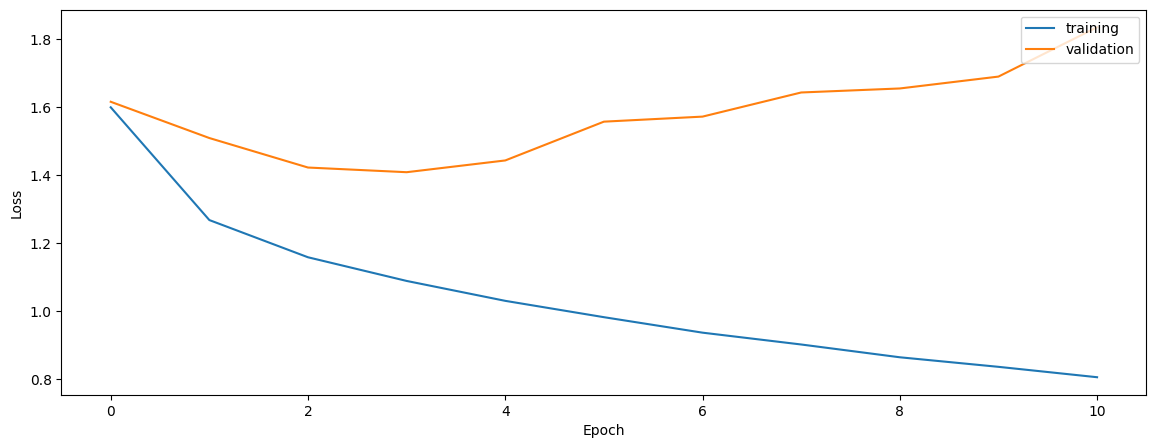

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5798833372658563
0.4591303254995601
0.483582779786429


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5313745128946101
0.45574708608341524
0.518578352180937


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5220694733264826
0.47015282301227596
0.5144950621216948


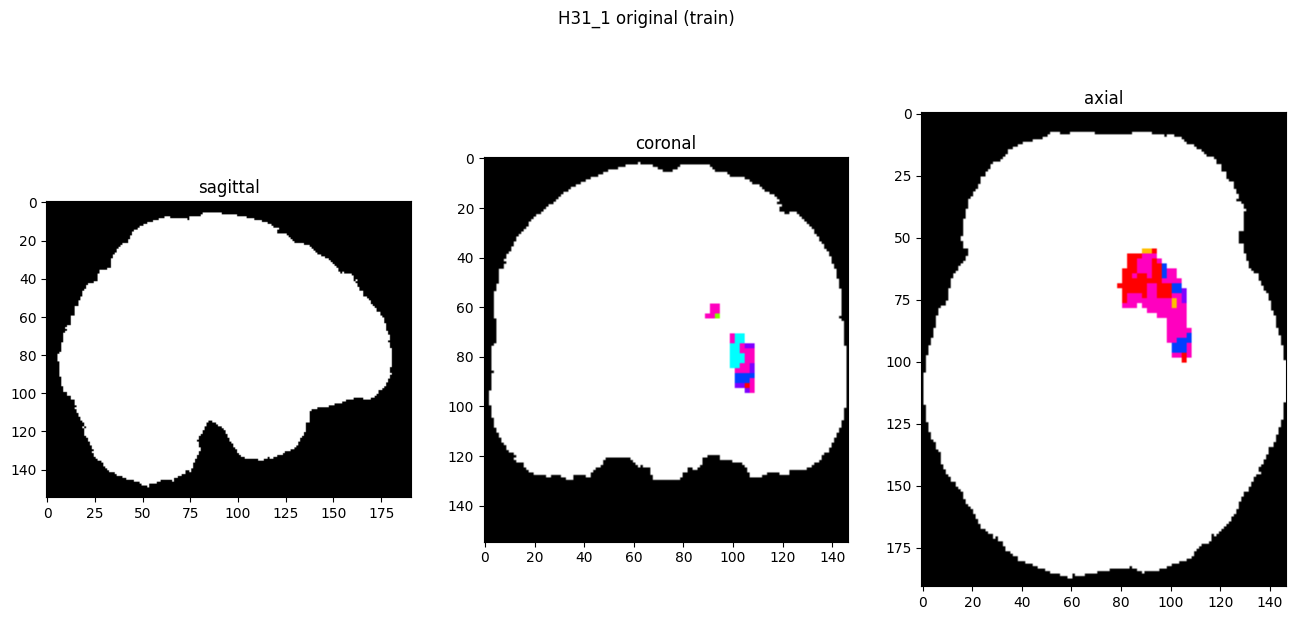

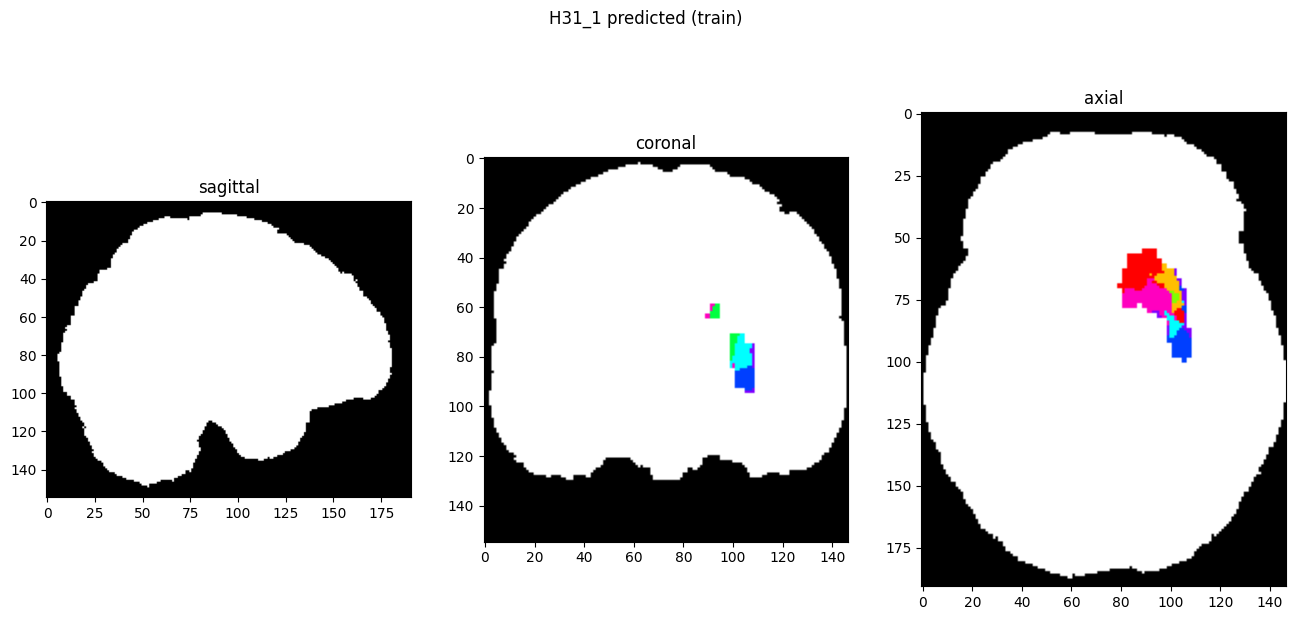

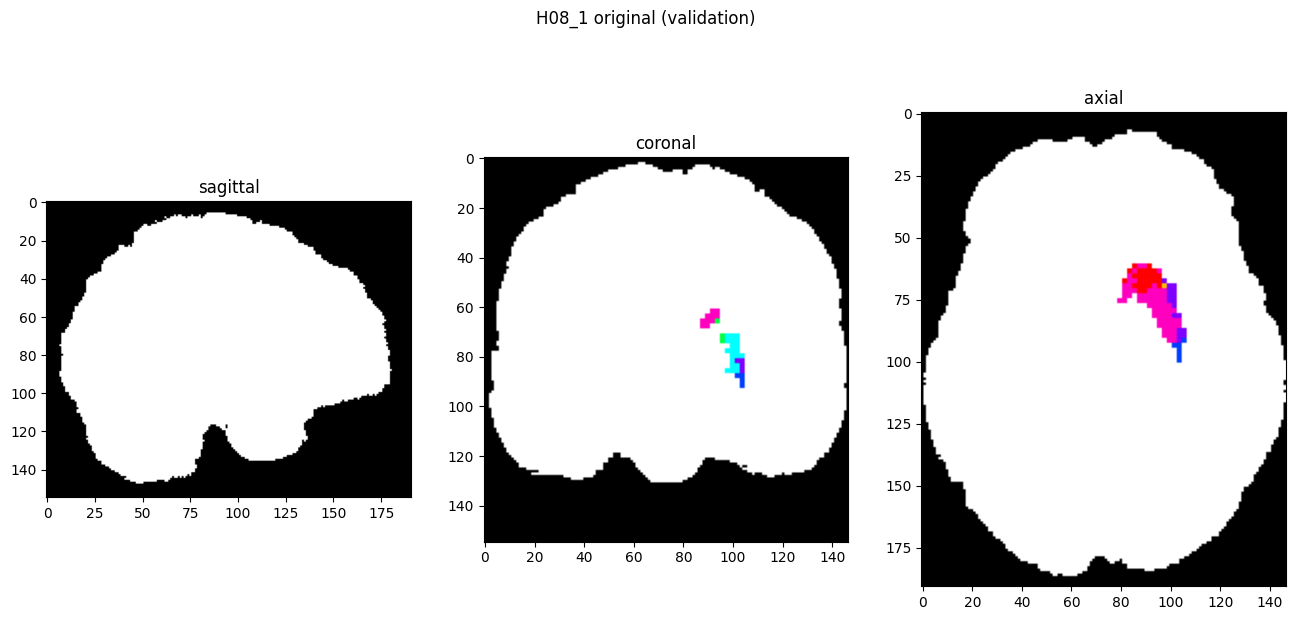

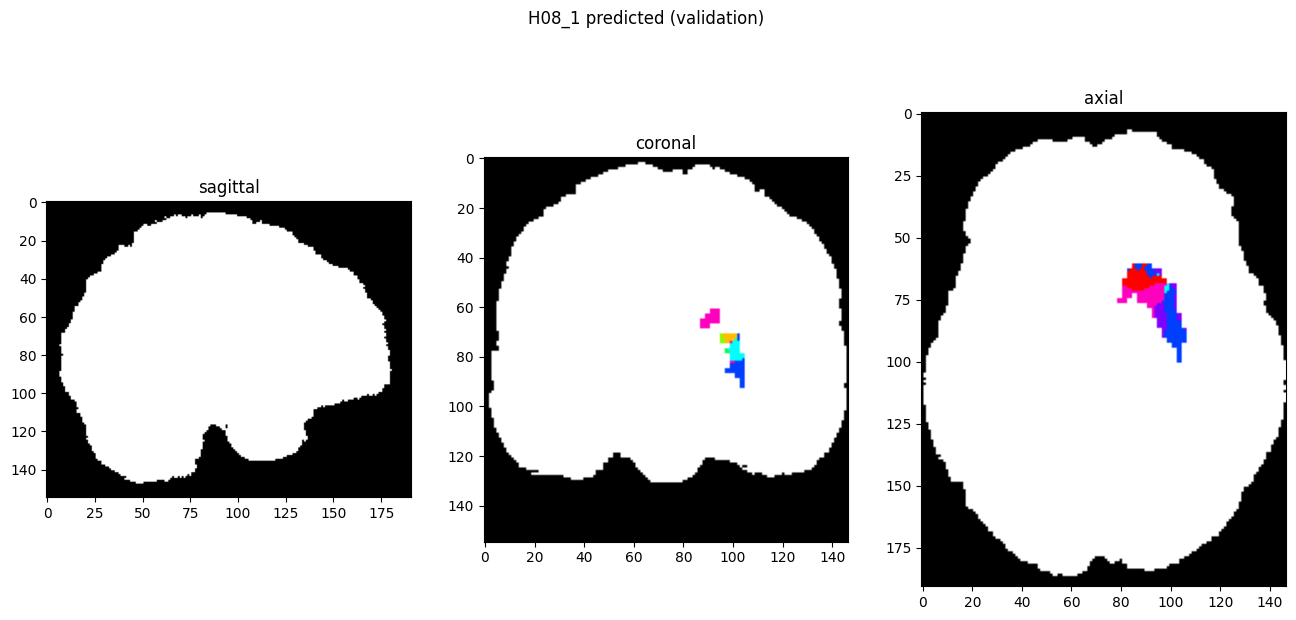

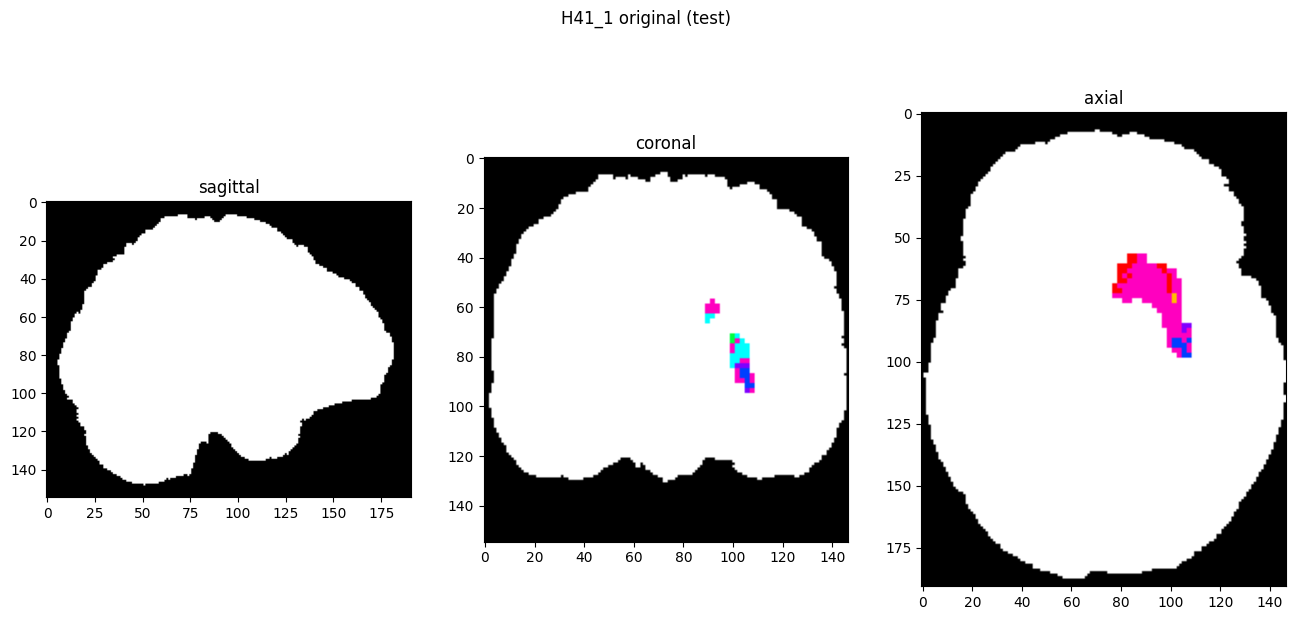

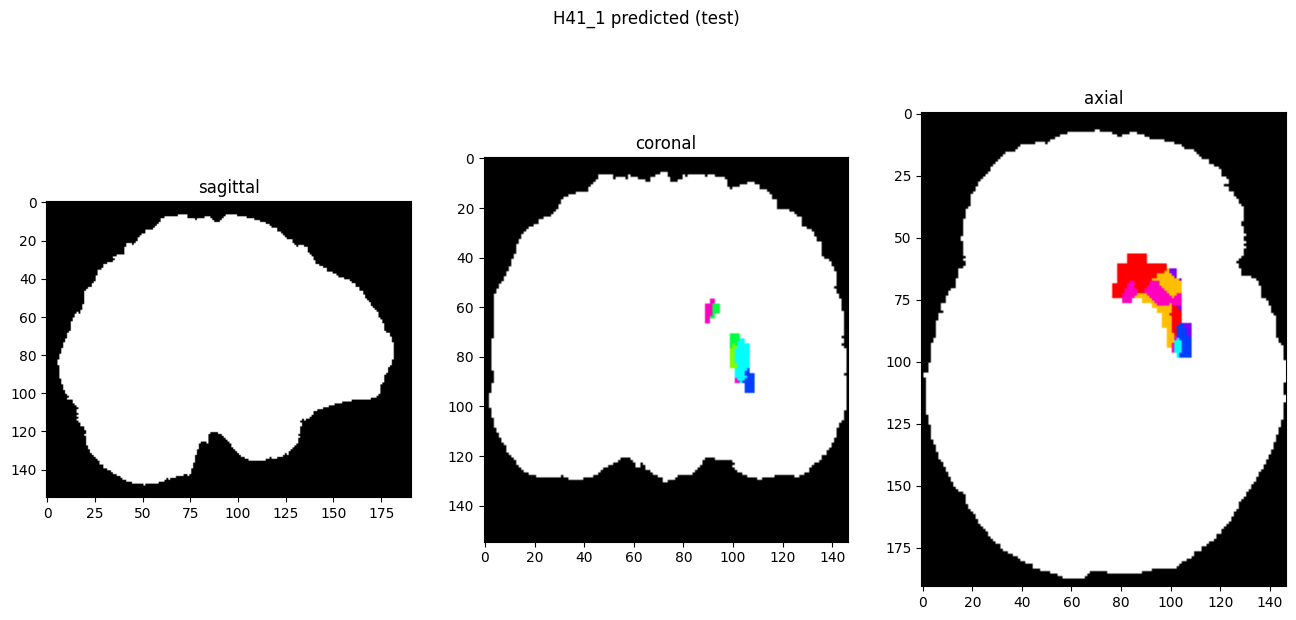

In [10]:
showResults(model, gen, threshold=0)